# Train
This notebook uses `./data/processed_data.pkl` and trains a ppo model. The final model is found in `./trained_models/ppo_14_5.pkl`. For demonstration of the training process with less total timesteps and outputs `./trained_models/ppo_14_5.pkl`. 

# Import libraries and data

In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git
## install wget
!pip install wget

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-crbt7c7a
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-crbt7c7a
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-dbp9fu36/pyfolio_e11273b082b0424caed5c88f55056ccd
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-dbp9fu36/pyfolio_e11273b082b0424caed5c88f55056ccd
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-dbp9fu36/elegantrl_326e85d12e7940128f0ec172cce2ffc7
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-dbp9fu36/elegantrl_326e85d12e7940128f0ec172cce2ffc7


In [24]:
## import libraries
# general utils
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import datetime
import calendar
# finrl library
from finrl import config
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
# tensot utils
from gym.utils import seeding
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv

# os and system file definitions
import sys
sys.path.append("../FinRL-Library")
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

# Load the TensorBoard notebook extension
import tensorflow as tf
%load_ext tensorboard

# download pre-processed data from github repo
url_df = 'https://github.com/changjulian17/DataSciencePortfolio/blob/main/Investment_Portfolio/data/processed_data.pkl?raw=true'
df = pd.read_pickle(url_df)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Multi-Asset Market - Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

## Training data split 2005-11-30 to 2020-01-01

In [25]:
train = data_split(df, '2005-11-30','2020-01-01')

In [26]:
train.shape

(28336, 16)

In [27]:
df.tail(8)

,date,month,close,volume,tic,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list,close_delta,close_30_sma_delta,close_60_sma_delta
31696,2021-08-31,08,115.529648,6763900.0,AGG,0.074366,54.712175,18.359943,9.738954,115.506626,115.054341,"[[4.180271969668594e-06, -1.8830269083932926e-...",tic AGG COM CSH EEM ...,-0.001464,-0.000050,0.000257
31697,2021-08-31,08,95.989998,0.0,COM,0.272569,55.300050,77.088322,14.459062,94.940666,94.148000,"[[4.180271969668594e-06, -1.8830269083932926e-...",tic AGG COM CSH EEM ...,-0.001977,0.000941,0.000324
31698,2021-08-31,08,1.000000,0.0,CSH,0.000000,55.300050,77.088322,14.459062,1.000000,1.000000,"[[4.180271969668594e-06, -1.8830269083932926e-...",tic AGG COM CSH EEM ...,0.000000,0.000000,0.000000
31699,2021-08-31,08,52.410000,43226700.0,EEM,-0.276504,49.906189,78.207188,6.277385,51.614666,53.012122,"[[4.180271969668594e-06, -1.8830269083932926e-...",tic AGG COM CSH EEM ...,0.013640,-0.000291,-0.000961
31700,2021-08-31,08,630.590000,0.0,GLD,0.496968,52.402475,83.613562,6.277385,622.136000,626.241500,"[[4.180271969668594e-06, -1.8830269083932926e-...",tic AGG COM CSH EEM ...,0.009048,-0.000153,-0.000680
31701,2021-08-31,08,116.926018,7418400.0,IEF,0.076883,53.687621,-14.855701,7.496965,117.068840,116.272461,"[[4.180271969668594e-06, -1.8830269083932926e-...",tic AGG COM CSH EEM ...,-0.001876,-0.000160,0.000378
31702,2021-08-31,08,190.572196,0.0,LOV,-0.400142,1.183841,-45.454545,7.496965,191.162715,192.190168,"[[4.180271969668594e-06, -1.8830269083932926e-...",tic AGG COM CSH EEM ...,0.000000,-0.000386,-0.000258
31703,2021-08-31,08,9433.580078,0.0,SNP,77.304140,62.965117,167.127295,21.356673,9250.471322,9087.068766,"[[4.180271969668594e-06, -1.8830269083932926e-...",tic AGG COM CSH EEM ...,-0.001235,0.001557,0.001184


## Environment for Portfolio Allocation

In [28]:
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        initial_amount : int
            start money
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                initial_amount,
                state_space,
                action_space,
                tech_indicator_list,
                day = 0,
                drg_wt = [.095,.19,.05, .095,.19,.095,.19,.095]):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.stock_dim = stock_dim
        self.initial_amount = initial_amount
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list
        self.drg_wt = drg_wt

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, 
                                       high = 1,
                                       shape = (self.action_space,)
                                       ) 
        # Shape = (34, 30)
        # covariance matrix + technical indicators
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape = (self.state_space+len(self.tech_indicator_list),
                                                     self.state_space)
                                            )

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), 
                                [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], 
                                axis=0
                                )
        self.terminal = False     
        # initalize portfolio value
        self.portfolio_value = self.initial_amount

        # initialize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # initialize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[0, 0, 1, 0, 0, 0, 0, 0]]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            # actions are the portfolio weight
            weights = self.softmax_normalization(actions)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), 
                                    [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], 
                                    axis=0
                                    )
            # calcualte portfolio return
            # individual stocks' return * weight
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
            # update portfolio value
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # calculate daily return of dragon portfolio
            day_returns = (self.data.close.values / last_day_memory.close.values) - 1
            benchmark = np.average(day_returns, axis=0, weights=self.drg_wt)

            # reward is agent return less daily return of dragon portfolio
            self.reward = (portfolio_return - benchmark)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), 
                                [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], 
                                axis=0
                                )
        self.portfolio_value = self.initial_amount
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory=[[0, 0, 1, 0, 0, 0, 0, 0]]
        self.date_memory=[self.data.date.unique()[0]] 
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator/denominator
        return softmax_output

    
    def save_asset_memory(self):
        # return an updated list of portfolio daily returns
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # return an updated list of portfolio daily weights
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [32]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 8, State Space: 8


## Hyperparameters

In [33]:
# initialise stock indicators used
tech_indicator_list = ["macd",
                      "rsi_30",
                      "cci_30",
                      "dx_30",
                      "close_30_sma",
                      "close_60_sma",
                      # # adding columns to give as states
                      "month",
                      "close",
                      "close_delta",
                      "close_30_sma_delta",
                      "close_60_sma_delta",
                      ]

# initialise dragon portfolio
drg_wt = [.095,.19,.05, .095,.19,.095,.19,.095]

# initialise environment arguments
env_kwargs = {
    "initial_amount": 1000000,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension,
    "drg_wt": drg_wt
}

# initialise a training gym
e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
# initialise a subenvironment from the training gym
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


# DRL PPO - Agent
Initialise the agent

In [34]:
# initialise FinRL agent class with train envirronment
agent = DRLAgent(env = env_train)

# initialise model arg
PPO_PARAMS = {
    "n_steps": 20_480,
    "ent_coef": .01,
    "learning_rate": .001,
    "batch_size": 5_120,
    "gamma": .99,
    "gae_lambda":.95,
    "clip_range": 0.3,
    "vf_coef": .5,
}

# initialise train model
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 20480, 'ent_coef': 0.01, 'learning_rate': 0.001, 'batch_size': 5120, 'gamma': 0.99, 'gae_lambda': 0.95, 'clip_range': 0.3, 'vf_coef': 0.5}
Using cpu device


# Train model

Below is a demonstration of how this model trains

In [38]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=60_000)
                  # actual run was 10_240_000 total timesteps
                  # but that run is 7 hours

begin_total_asset:1000000
end_total_asset:1840372.158329445
Sharpe:  0.6093991491529558
begin_total_asset:1000000
end_total_asset:1872826.9020130082
Sharpe:  0.6203392074658518
begin_total_asset:1000000
end_total_asset:1871785.4845743075
Sharpe:  0.6201009012557478
begin_total_asset:1000000
end_total_asset:1817337.3464632365
Sharpe:  0.5959439785166095
begin_total_asset:1000000
end_total_asset:1705818.0999160397
Sharpe:  0.5363819183450634
--------------------------------------
| time/              |               |
|    fps             | 451           |
|    iterations      | 1             |
|    time_elapsed    | 45            |
|    total_timesteps | 20480         |
| train/             |               |
|    reward          | 0.00050987955 |
--------------------------------------
begin_total_asset:1000000
end_total_asset:1931257.6144655328
Sharpe:  0.6410993973504125
begin_total_asset:1000000
end_total_asset:1768472.830908391
Sharpe:  0.5720989182788127
begin_total_asset:1000000
en

## State, Action, Reward - Sample

In [40]:
## Sample a state
data = train.loc[5,:]
covs = data['cov_list'].values[0] # grab cov matrix for each asset

# state is the cov matrix of each asset and technical indicators there after
state =  np.append(np.array(covs), [data[tech].values.tolist() for tech in tech_indicator_list], axis=0)
col_list = list(data.tic) + list(tech_indicator_list)
pd.DataFrame(state.T,index=data.tic, columns = col_list)

,AGG,COM,CSH,EEM,GLD,IEF,LOV,SNP,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,month,close,close_delta,close_30_sma_delta,close_60_sma_delta
tic,,,,,,,,,,,,,,,,,,,
AGG,4.416778755275253e-06,1.080967570173111e-06,0.0,-7.462479235585551e-07,1.8440620808377545e-07,5.491991280446865e-06,8.430838876422373e-07,8.677651933579501e-08,0.029279896348313628,49.82298603900799,1.4404929764754923,16.93873316645349,60.69542007446289,60.880045318603514,12,60.854331970214844,-0.003397117256434759,0.00018423612801631443,-0.00018952101392753616
COM,1.080967570173111e-06,0.0001148925226888228,0.0,1.1038746094739733e-05,2.0090989154224094e-05,1.8050444652977108e-06,2.9871810511499345e-06,-6.730588317379621e-07,1.5961208071951205,56.595497303859936,189.97911745501605,42.053504541447055,167.8393346150716,171.0193333943685,12,175.2899932861328,-0.013373581177095747,0.0005204733445735993,0.0006824168737465674
CSH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.595497303859936,189.97911745501605,42.053504541447055,1.0,1.0,12,1.0,0.0,0.0,0.0
EEM,-7.462479235585551e-07,1.1038746094739733e-05,0.0,0.00014672166200257837,7.12512427536956e-06,-1.6052261129737999e-06,4.53334904690125e-06,5.814737354086275e-05,0.36865008708220515,60.11312751133165,106.50686531827611,22.650625221927758,20.417188962300617,20.105375035603842,12,21.31515121459961,0.010154939088231838,0.0036624208662142856,0.0012930809771256905
GLD,1.8440620808377545e-07,2.0090989154224094e-05,0.0,7.12512427536956e-06,5.3795845087618674e-05,3.10713798102963e-07,2.317971226091753e-07,-7.997369320405355e-07,4.361899936538805,74.0860225234907,166.71154997007812,22.650625221927758,167.73266666666666,165.0955,12,182.59,0.018796506736317407,0.0036174397064210697,0.0026757674169327916
IEF,5.491991280446865e-06,1.8050444652977108e-06,0.0,-1.6052261129737999e-06,3.10713798102963e-07,1.0079095235884332e-05,7.157531041367367e-07,-7.951081172111325e-07,0.04165749083864512,49.20730954768066,24.77266071052885,5.70375631546675,55.466549173990884,55.70434284210205,12,55.6365966796875,-0.004446929506263153,0.000256991479898803,-0.00029810421296184596
LOV,8.430838876422373e-07,2.9871810511499345e-06,0.0,4.53334904690125e-06,2.317971226091753e-07,7.157531041367367e-07,1.2925457649386392e-05,7.745162472829332e-07,0.702124174510601,84.37822440498319,126.89835556468984,5.70375631546675,103.89357558586534,102.6371918469326,12,105.21255228819,0.0,0.001535964536563098,0.00039043411123668934
SNP,8.677651933579501e-08,-6.730588317379621e-07,0.0,5.814737354086275e-05,-7.997369320405355e-07,-7.951081172111325e-07,7.745162472829332e-07,4.213185147341795e-05,18.560701063685883,59.35949085363479,74.41538790712225,24.330910034744953,1867.469677734375,1839.700838216146,12,1902.9200439453125,0.0028154796903289998,0.001936040607199109,0.0005172475190529623


In [41]:
## Sample an action
# action is the portfolio allocation on each day
e_train_gym.save_action_memory()

,AGG,COM,CSH,EEM,GLD,IEF,LOV,SNP
date,,,,,,,,
2005-12-02,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2005-12-05,0.089901,0.089901,0.188112,0.121220,0.124347,0.089901,0.089901,0.206718
2005-12-06,0.096124,0.187854,0.096124,0.215751,0.096124,0.096124,0.096124,0.115775
2005-12-07,0.202436,0.202436,0.074472,0.074472,0.074472,0.074472,0.094804,0.202436
2005-12-08,0.068333,0.068333,0.185749,0.068333,0.185749,0.185749,0.169422,0.068333
...,...,...,...,...,...,...,...,...
2010-10-12,0.191590,0.073064,0.112198,0.073064,0.073064,0.198607,0.152344,0.126070
2010-10-13,0.091146,0.091146,0.091146,0.246993,0.113688,0.093672,0.091146,0.181062
2010-10-14,0.090201,0.245192,0.090201,0.090201,0.090201,0.090201,0.213601,0.090201


<Axes: >

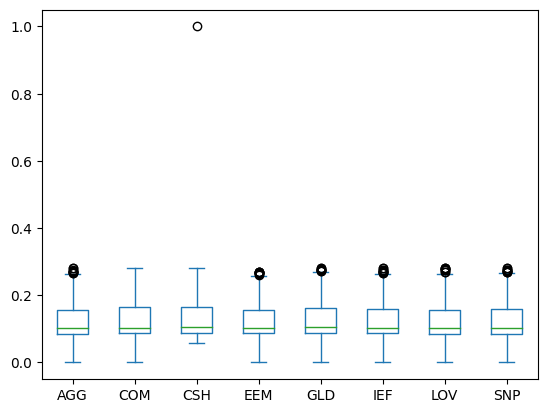

In [42]:
%matplotlib inline
e_train_gym.save_action_memory().plot(kind='box')

In [43]:
## Sample a reward
# reward in this case is the total asset value
e_train_gym.asset_memory[-5:]

[1579463.7009440917,
 1591779.529492865,
 1590689.2605115718,
 1585885.7211900437,
 1590984.4155016472]

## Saved Model

In [44]:
trained_ppo.save('./trained_models/ppo_demo.pkl')

# Trading
Assume that we have $1,000,000 initial capital at 2020-01-01. A pre-trained PPO model trades the 5 assets daily till 2021-09-01.

### Compute trading data and functions

In [45]:
from pyfolio import timeseries

# fxn to predict returns for 2020-01-01 to 2021-09-01
def new_prediction(model, environment):
    test_env, test_obs = environment.get_sb_env()
    """make a prediction"""
    account_memory = []
    actions_memory = []
    test_env.reset()
    for i in range(len(environment.df.index.unique())):
        action, _states = model.predict(test_obs,deterministic=True)
        # account_memory = test_env.env_method(method_name="save_asset_memory")
        # actions_memory = test_env.env_method(method_name="save_action_memory")
        test_obs, rewards, dones, info = test_env.step(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")
        if dones[0]:
            print("hit end!")
            break

    ann_ret = (np.prod([d_ret + 1 for d_ret in account_memory[0].daily_return])-1)/(24-4)*12
    print(f'Return of DRL Agent {ann_ret*100:.2f}%')

    return account_memory[0], actions_memory[0]

In [46]:
# get test data
trade = data_split(df,'2020-01-01', '2021-8-31')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

# initialise trade model
trade_model = DRLAgent(env = e_trade_gym).get_model("ppo",
                                                    model_kwargs = PPO_PARAMS)

# predict trades
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)

{'n_steps': 20480, 'ent_coef': 0.01, 'learning_rate': 0.001, 'batch_size': 5120, 'gamma': 0.99, 'gae_lambda': 0.95, 'clip_range': 0.3, 'vf_coef': 0.5}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/erenkotar/Desktop/tez_app_rl_2/thesis_env_2/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000000
end_total_asset:1175813.3627850905
Sharpe:  1.0613302807262546
hit end!


## Tensorboard

In [20]:
# %tensorboard --logdir /content/tensorboard_log/ppo

(continued on eval.ipynb)